In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [4]:
#plotting funcs
def create_time_steps(length):
    return list(range(-length,0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.set_ylim(0,1)
  return plt
def multi_step_plot(history, true_future, prediction,past_history,future_target, lim = (0,1)):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  STEP=1
  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1)) 

  plt.show()
def plot_history_true(history, true_future, prediction,past_history,future_target, lim = (0,1)):
  plt.figure(figsize=(12, 6))
  plt.axes(ylim=(-2,2))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  STEP=1
  plt.plot(num_in, np.array(history[:, 0]), label='History',scaley = False)
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future',scaley = False)
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1)) 

  plt.show()

In [5]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
def plot_train_history_acc(history, title):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(accuracy))

  plt.figure()

  plt.plot(epochs, accuracy, 'b', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

In [6]:

#find all the filenames
filenames = []
basepath = 'PML\output'
with os.scandir(basepath) as entries:
    for entry in entries:
        if entry.is_file():
            filenames.append(entry.name)

In [7]:
#Read in the datasets
DATASETS = {}
STATES = []
for filename in filenames:
    DATASETS[filename[:-4]] = pd.read_csv("PML\output\\" + filename)
    STATES.append(filename[:-4])

In [8]:
#DATASETS["Alabama"].head()

In [9]:
""" Converting from actual values to per 100k.
Formula (cases/pop )*100,000
for every value that would differ based on pop"""
#generator for per100k poop
def gen_per100k(pop):
    def per_100k(val):
        if val == 0:
            return 0
        else:
            return (val*100000)/pop
    return per_100k
#list of cols to scale
scalelist = ["Cases","Difference","positive","negative",\
            "hospitalizedCumulative","death","death","deathIncrease"]
DATASETS_SCALED = {}
for key,val in DATASETS.items():
    func = gen_per100k(val["Population_Count"][0])
    DATASETS_SCALED[key] = DATASETS[key].copy()
    for col in scalelist:
        DATASETS_SCALED[key][col] = DATASETS_SCALED[key][col].apply(func)
    


In [10]:
#remove unneeded coloms
DATASETS_SR = {}
droplist = ["People_Total_Tested_Count","recovered","Population_Count","LandArea"]
for key,val in DATASETS_SCALED.items():
    DATASETS_SR[key] = DATASETS_SCALED[key].copy()
    DATASETS_SR[key] = DATASETS_SR[key].drop(columns=droplist)

In [11]:
#DATASETS_SCALED["Alabama"].head()

In [12]:
#DATASETS_SR["Alabama"]

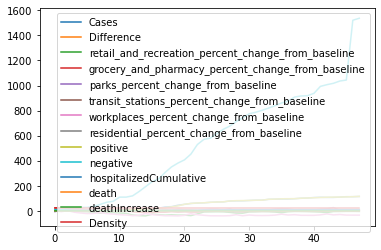

In [13]:
DATASETS_SR["Idaho"].plot()

In [14]:
state = "New York"
COLNAMES = list(DATASETS_SR[state].columns)
features_considered = COLNAMES
features_considered.remove("date")
#features_considered.remove("Density")
features = DATASETS_SR[state][features_considered].copy()
features.index = DATASETS_SR[state]['date']
features.head()


,Cases,Difference,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,positive,negative,hospitalizedCumulative,death,deathIncrease,Density
date,,,,,,,,,,,,,,
2020-03-04,0.042053,0.034407,8.508197,6.000000,5.278689,1.311475,3.065574,-0.213115,0.022938,0.183505,0.0,0.0,0.0,412.5211
2020-03-05,0.087930,0.045876,11.442623,9.213115,11.836066,2.967213,3.868852,-1.016393,0.084107,0.290550,0.0,0.0,0.0,412.5211
2020-03-06,0.118514,0.030584,1.934426,0.278689,1.114754,2.327869,2.836066,0.475410,0.126160,0.351719,0.0,0.0,0.0,412.5211
2020-03-07,0.290550,0.172036,15.327869,7.491803,16.737705,6.032787,4.590164,-0.852459,0.290550,0.351719,0.0,0.0,0.0,412.5211
2020-03-08,0.405241,0.114691,19.393443,11.918033,34.245902,5.901639,4.114754,-0.754098,0.401418,0.351719,0.0,0.0,0.0,412.5211


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021EE6815948>,
      dtype=object)

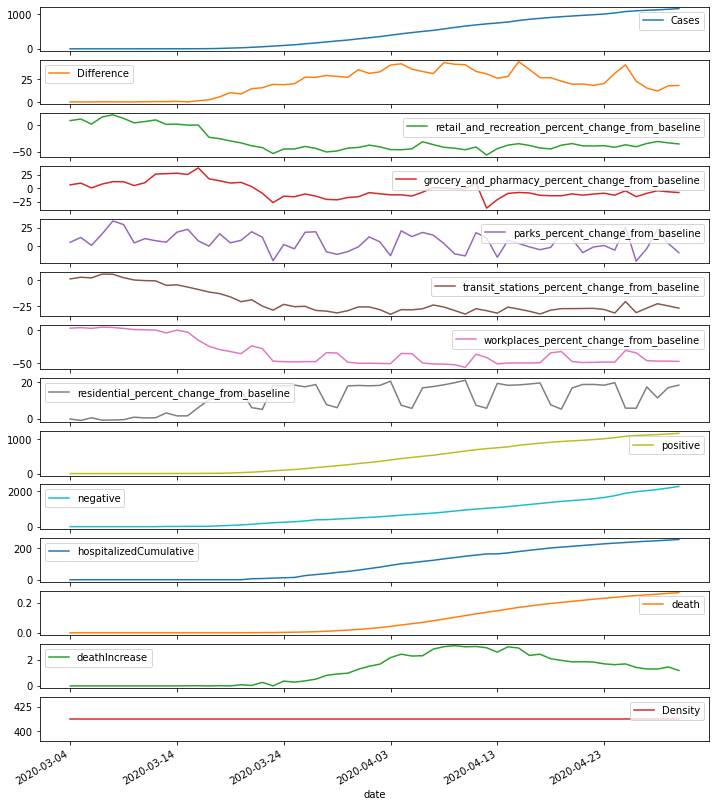

In [15]:
features.plot(subplots=True,figsize = (12,15))

def gen_per100k(pop):
    def per_100k(val):
        if val == 0:
            return 0
        else:
            return (val*100000)/pop
    return per_100k
#list of cols to scale
scalelist = ["Cases","Difference","positive","negative",\
            "hospitalizedCumulative","death","death","deathIncrease"]
DATASETS_SCALED = {}
for key,val in DATASETS.items():
    func = gen_per100k(val["Population_Count"][0])
    DATASETS_SCALED[key] = DATASETS[key].copy()
    for col in scalelist:
        DATASETS_SCALED[key][col] = DATASETS_SCALED[key][col].apply(func)

#norm the length of each datasets
DATASETS_UF = {}
counts = [len(DATASETS_SR[key].index) for key,val in DATASETS_SR.items()]
print(max(counts))
for key,val in DATASETS_SR.items():
    DATASETS_UF[key] = DATASETS_SR[key].copy()
    DATASETS_UF[key] = DATASETS_UF[key].head(min(counts))
print(min(counts))

In [16]:
#proccess data by removing uneeded rows and making the data the the index along with 
#transforming all culmative into diffrense

F_LIST = []
for state in STATES:
    COLNAMES = list(DATASETS_SR[state].columns)
    features_considered = COLNAMES
    features_considered.remove("date")
    features_considered.remove("Density")
    #remove all culmative that won't be scaled
    features_considered.remove("death")
    features_considered.remove("Cases")
    features = DATASETS_SR[state][features_considered].copy()
    features.index = DATASETS_SR[state]['date']
    #convert all culmatives into diffrences
    features["positive"] = features["positive"].diff()
    features["negative"] = features["negative"].diff()
    features["hospitalizedCumulative"] = features["hospitalizedCumulative"].diff()
    features = features.fillna(0)
    F_LIST.append(features)



In [17]:
"""This function splits up a states dataset into a rolling window of historys and predictions"""
test_ds = DATASETS_SR["Alabama"].values
def make_windows(ds, hist_size = 7, pred_size=3, pred_col=0):
    test_ds = ds.values
    history_size = hist_size
    prediction_size = pred_size
    pred_col = pred_col
    test_hist = []
    test_pred = []
    for i in range(0,test_ds.shape[0]-history_size-prediction_size+1):
        test_hist.append(test_ds[i:i+history_size])
        test_pred.append(test_ds[i+history_size:i+history_size+prediction_size,pred_col])
    return test_hist,test_pred
test_x,test_y = make_windows(F_LIST[15],pred_size=6)


In [18]:
#history to use for prediction
history_size = 25
#days to predict
prediction_size = 5
pred_col = 0
#percent to remove for validation
val_percent = .2

In [19]:
#find the number of datapoints
all_ds = [len(make_windows(F_LIST[x],history_size\
                           ,prediction_size,pred_col)[0]) for x in range(0,len(F_LIST))]
datapoints_size = sum(all_ds)

In [20]:
#create a list of all states history/pred data
all_history = []
all_pred = []
for x in range(0,len(F_LIST)):
    temp_x, temp_y = make_windows(F_LIST[x],history_size,prediction_size,pred_col)
    all_history = all_history + temp_x
    all_pred = all_pred + temp_y
    
#convert into np arrays
ds_x = np.array(all_history)
ds_y = np.array(all_pred)

#shuffle the history/pred slices in order to extract val set randomly (states  w/larger # of days will be represented more)
np.random.seed(0) #set for reuse
p = np.random.permutation(len(ds_x))
ds_x_shuffled = ds_x[p]
ds_y_shuffled = ds_y[p]

#find the number of validation cases needed
num_val_cases = int(datapoints_size*val_percent)
print("Number of validation cases: {} \nNumber of training cases: {}".format(num_val_cases,datapoints_size-num_val_cases))

#seperate into train and test sets
x_test = ds_x[0:num_val_cases]
y_test = ds_y[0:num_val_cases]
x_train = ds_x[num_val_cases:]
y_train = ds_y[num_val_cases:]

Number of validation cases: 256 
Number of training cases: 1025


In [21]:
#utils for standarization/normalization
USE_STANDARD = False
if USE_STANDARD:
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
else:
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
#stack x numpy array inorder to fit (col wise) bc in windows of 7
stacked_x_train=x_train.reshape(len(x_train)*history_size,x_train.shape[2])
stacked_x_test=x_test.reshape(len(x_test)*history_size,x_test.shape[2])
#fit the scalers
x_scaler.fit(stacked_x_train)
y_scaler.fit(y_train)
#transofr the training data
stacked_x_train =x_scaler.transform(stacked_x_train)
y_train = y_scaler.transform(y_train)

#transform the validation data (FORGOT TO DO THIS AND WAS CONFUSED BY MSE OF 80)
stacked_x_test = x_scaler.transform(stacked_x_test)
y_test = y_scaler.transform(y_test)

#transform the stacked x data back to right size
x_train = stacked_x_train.reshape(len(x_train),history_size,x_train.shape[2])
x_test = stacked_x_test.reshape(len(x_test),history_size,x_test.shape[2])


import seaborn as sns
df = pd.concat(F_LIST["New York"])
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

df = pd.DataFrame(F_LIST[0])
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [22]:

x_train_single = x_train
y_train_single = y_train
x_val_single = x_test
y_val_single = y_test
print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

(1025, 25, 11)
(1025, 5)
(256, 25, 11)
(256, 5)


In [23]:
BATCH_SIZE = 15
BUFFER_SIZE = 60

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_multi = train_data_multi.cache().shuffle(buffer_size=BUFFER_SIZE,seed = 0).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_single,  y_val_single))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


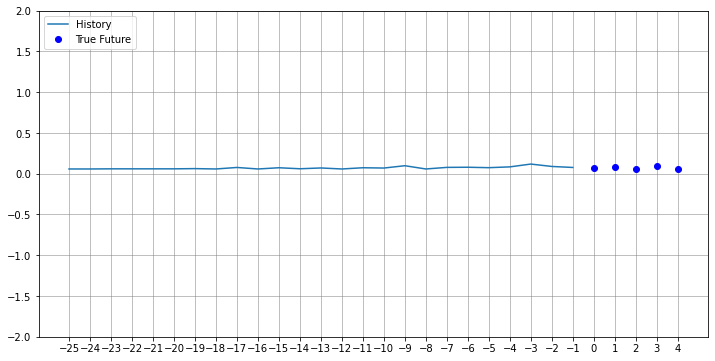

In [24]:
for x, y in train_data_multi.take(1):
  plot_history_true(x[0], y[0], np.array([0]),history_size,prediction_size,lim=(0,2))



#builds the model
def build_model(optimizer = "sgd",init_mode = "uniform",lstm1_n = 32, lstm2_n=16):
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_n,\
                                              activation='sigmoid',
                                              return_sequences=True,
                                              input_shape=x_train_single.shape[-2:],\
                                              kernel_initializer=init_mode,dropout = 0.01)))
    model.add(tf.keras.layers.LSTM(lstm2_n, activation='tanh',kernel_initializer=init_mode))
    model.add(tf.keras.layers.Dense(prediction_size,kernel_initializer=init_mode))
    model.compile(optimizer = optimizer, loss="mse",metrics=["accuracy"])
    return model

In [25]:
#builds the model
def build_model(dropout = 0.1,optimizer = "adam",init_mode = "uniform",lstm1_n = 32, lstm2_n=16,loss = 'mean_absolute_error',activation = "relu"):
    model = Sequential()
    model.add(Bidirectional(tf.keras.layers.LSTM(lstm1_n,\
                         activation=activation,
                        return_sequences=True,
                        input_shape=x_train_single.shape[-2:],\
                        kernel_initializer=init_mode,dropout = dropout)))
    model.add(tf.keras.layers.LSTM(lstm2_n, activation=activation,kernel_initializer=init_mode))
    model.add(tf.keras.layers.Dense(prediction_size,kernel_initializer=init_mode,activation="relu"))
    model.compile(optimizer = optimizer, loss='mean_absolute_error',metrics=["accuracy"])
    return model

In [ ]:
GRID = True
if GRID == True:
    model = KerasClassifier(build_fn=build_model)
    #param_grid = dict(epochs=[5,10,15])
    epochs = [15]
    lstm1_n = [32,64]
    lstm2_n=  [8,16,32]
    batch_size = [20]
    dropout = [0.1,0.3]
    init_mode = ['uniform']
    activation = ['relu', 'tanh', 'sigmoid']
    optimizer = ['SGD', 'Adam']
    loss = ["mse"]
    param_grid = dict(loss = loss, dropout = dropout,activation = activation,init_mode=init_mode, epochs= epochs,lstm1_n=lstm1_n,lstm2_n=lstm2_n,batch_size=batch_size,optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3,verbose = 2,return_train_score = True)
    grid_result = grid.fit(x_train_single,y_train_single,validation_data=(x_val_single,y_val_single),verbose = 0)
    grid_result.best_params_
    grid_result.best_score_
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    import pickle
    pickle.dump( grid_result.best_params_, open( "best_params2.p", "wb" ) )
    pickle.dump( grid_result.best_score_, open( "best_scores2.p", "wb" ) )

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


683/683 [==============================] - 0s 667us/sample - loss: 0.9364 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.9s
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s remaining:    0.0s


683/683 [==============================] - 0s 683us/sample - loss: 0.9095 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.4s
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 677us/sample - loss: 0.8843 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.3s
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 679us/sample - loss: 0.8823 - accuracy: 0.0893
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam, total=  29.8s
[CV] activation=relu, batc

683/683 [==============================] - 0s 670us/sample - loss: 0.8887 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=  29.2s
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 668us/sample - loss: 0.9063 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=  29.6s
[CV] activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 669us/sample - loss: 0.8916 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam, total=  29.4s
[CV] activation=relu, 

683/683 [==============================] - 0s 686us/sample - loss: 0.9100 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.3s
[CV] activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 668us/sample - loss: 0.8827 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.4s
[CV] activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 676us/sample - loss: 0.8570 - accuracy: 0.0351
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam, total=  29.9s
[CV] activation=relu, batc

683/683 [==============================] - 0s 694us/sample - loss: 0.8864 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=  29.9s
[CV] activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 671us/sample - loss: 0.8851 - accuracy: 0.0000e+00
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=  29.4s
[CV] activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 669us/sample - loss: 0.8999 - accuracy: 0.0102
[CV]  activation=relu, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam, total=  29.5s
[CV] activation=relu, batc

683/683 [==============================] - 0s 221us/sample - loss: 0.9097 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=   9.1s
[CV] activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 214us/sample - loss: 0.9079 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=   8.6s
[CV] activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 216us/sample - loss: 0.9112 - accuracy: 0.0703
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam, total=   8.7s
[CV] activation=tanh, batc

683/683 [==============================] - 0s 222us/sample - loss: 0.9095 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=   8.6s
[CV] activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 223us/sample - loss: 0.8838 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=   9.4s
[CV] activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 219us/sample - loss: 0.8541 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam, total=   8.7s
[CV] activation=tanh, 

683/683 [==============================] - 0s 219us/sample - loss: 0.9085 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=   8.6s
[CV] activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 216us/sample - loss: 0.8847 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=   9.6s
[CV] activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 216us/sample - loss: 0.8521 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam, total=   8.7s
[CV] activation=tanh, 

683/683 [==============================] - 0s 222us/sample - loss: 0.9098 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=   8.6s
[CV] activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 217us/sample - loss: 0.9299 - accuracy: 0.0000e+00
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=SGD, total=  10.0s
[CV] activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 225us/sample - loss: 0.8639 - accuracy: 0.5212
[CV]  activation=tanh, batch_size=20, dropout=0.3, epochs=15, init_mode=uniform, loss=mse, lstm1_n=64, lstm2_n=8, optimizer=Adam, total=   8.7s
[CV] activation=tanh, batc

683/683 [==============================] - 0s 624us/sample - loss: 0.9353 - accuracy: 0.0000e+00
[CV]  activation=sigmoid, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  29.3s
[CV] activation=sigmoid, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD 
684/684 [==============================] - 0s 623us/sample - loss: 0.9322 - accuracy: 0.0000e+00
[CV]  activation=sigmoid, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=SGD, total=  30.8s
[CV] activation=sigmoid, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam 
683/683 [==============================] - 0s 622us/sample - loss: 0.9518 - accuracy: 0.0015
[CV]  activation=sigmoid, batch_size=20, dropout=0.1, epochs=15, init_mode=uniform, loss=mse, lstm1_n=32, lstm2_n=8, optimizer=Adam, total=  29.4s
[CV] activa

In [ ]:
#grid_result.best_params_

In [ ]:
multi_step_model = build_model(init_mode = 'uniform',\
                               lstm1_n=128,\
                               lstm2_n=64)
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

In [ ]:
val_data = (x_val_single,y_val_single)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
single_step_history = multi_step_model.fit(x_train_single,y_train_single,epochs=EPOCHS,\
                                           batch_size = 20,validation_data=val_data)

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
plot_train_history_acc(single_step_history,
                   'Single Step Training and validation accuracy')

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
plot_train_history_acc(single_step_history,
                   'Single Step Training and validation accuracy')

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
plot_train_history_acc(single_step_history,
                   'Single Step Training and validation accuracy')

In [ ]:
single_step_history.history.keys()

In [ ]:
#grid_result.best_params_["init_mode"]

In [ ]:
for x, y in val_data_multi.take(5):
  x_temp = np.array(x[0])
  y_temp = np.array(y)

  p_temp = np.array(multi_step_model.predict(x))
  x_unscaled = x_scaler.inverse_transform(x_temp)
  y_unscaled = y_scaler.inverse_transform(y_temp)
  p_unscaled = y_scaler.inverse_transform(p_temp)
  multi_step_plot(x_unscaled, y_unscaled[0], p_unscaled[0],history_size,prediction_size)

In [ ]:
results = multi_step_model.evaluate(x_val_single,y_val_single,verbose=2)

In [ ]:
results

In [ ]:
state = "New Jersey"
COLNAMES = list(DATASETS_SR[state].columns)
features_considered = COLNAMES
features_considered.remove("date")
features_considered.remove("Density")
features = DATASETS_SR[state][features_considered].copy()
features.index = DATASETS_SR[state]['date']
features.head()

data_v = features.values
    #datasets_norm.append((data_v-data_mean)/dat_std)
data_norm = (data_v-data_min)/data_max_min

In [ ]:
import seaborn as sns
df = features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
past_history = 7
future_target = 5
STEP = 1
#FIX HUGE ERROR HERE< need to std not on all
#lets get stacking folks
temp = np.copy(data_norm)
idaho_x, idaho_y = multivariate_data(temp, temp[:, 0], 0,\
                                                   None, past_history,\
                                                   future_target, STEP)


In [ ]:
data_v[:44,0]

In [ ]:
pred = multi_step_model.predict(idaho_x)

In [ ]:
pred.shape

In [ ]:
idaho_x[:,6,0]

In [ ]:
data_v[:,0].shape

In [ ]:
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_single,  y_val_single))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
x = np.linspace(0+5, 45+5,num=46)
x1 = np.linspace(10, 20)
plt.figure(figsize=(14, 6))
plt.plot(x, idaho_x[:,6,0]*data_max_min[0]+data_min[0], label='linear')

for i in range(0,pred.shape[0]):
    x_t = np.linspace(i+7,i+7+4,num=5)
    plt.plot(x_t, pred[i]*data_max_min[0]+data_min[0])
plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks(np.arange(0,44, step=1))
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
num_in = create_time_steps(len(history))
num_out = len(true_future)
    
plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1))
  plt.show()